# Model recovery attack: `credit-card`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import mra
from mra import *
import models
from models import *

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-04-05 05:32:59.509962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 05:33:00.505518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10078 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

In [5]:
main = {}

for dropout in [0.8,0.6,0.4,0.2]:
    print("Drop out = {}".format(dropout))
    main[dropout] = mra(train_ds)
    make_f, make_g, make_generator = models.make_mlp(
        attr_num=23,
        class_num=2,
        split=3,
        fg_units=64,
        fg_act="relu",
        generator_units=[512,256,128,64],
        dropout=dropout
    )
    main[dropout].train(
        make_f,
        make_g,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        batch_size=32,
        epoch=5,
        lr=0.001,
        verbose=True, log_every=1000
    )

Drop out = 0.8
Iteration 1000: Training loss: 0.4624
Iteration 2000: Training loss: 0.4452
Iteration 3000: Training loss: 0.4409
Iteration 4000: Training loss: 0.4363
Drop out = 0.6
Iteration 1000: Training loss: 0.4635
Iteration 2000: Training loss: 0.4429
Iteration 3000: Training loss: 0.4397
Iteration 4000: Training loss: 0.4355
Drop out = 0.4
Iteration 1000: Training loss: 0.4605
Iteration 2000: Training loss: 0.4435
Iteration 3000: Training loss: 0.4431
Iteration 4000: Training loss: 0.4382
Drop out = 0.2
Iteration 1000: Training loss: 0.4648
Iteration 2000: Training loss: 0.4441
Iteration 3000: Training loss: 0.4390
Iteration 4000: Training loss: 0.4404


In [6]:
log_attack = {}
for dropout in [0.8,0.6,0.4,0.2]:
    print("Dropout = {}".format(dropout))
    log_attack[dropout] = main[dropout].attack(
        attack_iter=100,
        make_generator=make_generator,
        input_noise="normal",
        input_z=True,
        model_leak=True,
        lr_x=0.0001,
        lr_f=0.00001,
        epoch=50,
        iter_x=40,
        iter_f=1,
        verbose=True, log_every=1
    )

Dropout = 0.8
Iteration 0001: RG-uniform: 0.2390, RG-normal: 0.2137, reconstruction validation: 0.0793
Iteration 0002: RG-uniform: 0.2387, RG-normal: 0.2016, reconstruction validation: 0.0357
Iteration 0003: RG-uniform: 0.2394, RG-normal: 0.2096, reconstruction validation: 0.0269
Iteration 0004: RG-uniform: 0.2434, RG-normal: 0.2004, reconstruction validation: 0.0326
Iteration 0005: RG-uniform: 0.2308, RG-normal: 0.2160, reconstruction validation: 0.0272
Iteration 0006: RG-uniform: 0.2387, RG-normal: 0.2123, reconstruction validation: 0.0137
Iteration 0007: RG-uniform: 0.2034, RG-normal: 0.1922, reconstruction validation: 0.0108
Iteration 0008: RG-uniform: 0.2291, RG-normal: 0.1953, reconstruction validation: 0.0119
Iteration 0009: RG-uniform: 0.2282, RG-normal: 0.2202, reconstruction validation: 0.0086
Iteration 0010: RG-uniform: 0.2322, RG-normal: 0.2128, reconstruction validation: 0.0107
Iteration 0011: RG-uniform: 0.2127, RG-normal: 0.2210, reconstruction validation: 0.0085
Iterati

In [7]:
import pickle
with open('./log/credit-dropout.pkl', 'wb') as f:
    pickle.dump(log_attack, f)

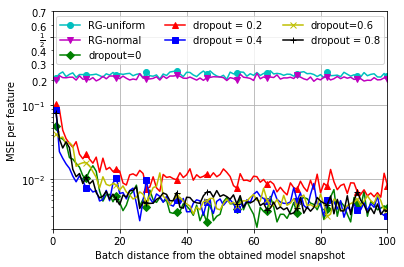

In [55]:
import matplotlib.pyplot as plt

with open('./log/credit.pkl', 'rb') as f:
    log_attack[0] = pickle.load(f)[3]

plt.yscale('logit')
plt.xlim([0,100])
plt.ylim([0.002,0.7])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
# plt.yticks([0.002,0.02,0.1,0.2,0.5], ['0.002','0.002','0.1','0.2','0.5'])
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[0][:,0], 'co-',
    ran, log_attack[0][:,1], 'mv-',
    ran, log_attack[0][:,2], 'gD-',
    ran, log_attack[0.2][:,2], 'r^-',
    ran, log_attack[0.4][:,2], 'bs-',
    ran, log_attack[0.6][:,2], 'yx-',
    ran, log_attack[0.8][:,2], 'k+-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'dropout=0', 'dropout = 0.2', 'dropout = 0.4', 'dropout=0.6', 'dropout = 0.8'], loc='upper center', ncol=3)
plt.savefig("fig/mra-dropout.pdf", bbox_inches='tight')